### Queries

In [1]:
#start solr server using bin/solr start (mac)
#perform queries using http requests

In [1]:
import requests
from datetime import datetime

#### 1) Query by categoryName

In [31]:
def query_by_category_name(solr_url, collection_name, category_name, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters
    params = {
        'q': f'categoryName:"{category_name}"',  # Filter by CategoryName
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        
        print(f'Top {num_results} results with CategoryName "{category_name}":')
        print(f'Execution Time: {execution_time} ms\n')
        
        # # Process grouped results and print documents
        # for group in grouped_results:
        #     restaurant_doc = group['doclist']['docs'][0]
        #     print(restaurant_doc)

        # Process grouped results and print top restaurants with category name
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, categoryName: {restaurant_doc['categoryName']}")
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
category_name = 'chinese restaurant'  # Specify the CategoryName to filter by
query_by_category_name(solr_url, collection_name, category_name)


Top 20 results with CategoryName "chinese restaurant":
Execution Time: 107.0 ms

Restaurant: 88 Seafood, categoryName: Chinese restaurant
Restaurant: Song Hua Jiang Restaurant, categoryName: Chinese restaurant
Restaurant: Hillman 99 Restaurant, categoryName: Chinese restaurant
Restaurant: Crystal Jade Hong Kong Kitchen, categoryName: Chinese restaurant
Restaurant: East Treasure Chinese Restaurant (東寶) Woods Square, categoryName: Chinese restaurant
Restaurant: Weng Jia Cai 翁家菜, categoryName: Chinese restaurant
Restaurant: Uncle Leong Signatures (FairPrice Hub), categoryName: Chinese restaurant
Restaurant: Peach Garden @ Thomson Plaza, categoryName: Chinese restaurant
Restaurant: Feng Shui Inn, categoryName: Chinese restaurant
Restaurant: Paradise Classic, categoryName: Chinese restaurant
Restaurant: J.B. Ah Meng Restaurant, categoryName: Chinese restaurant
Restaurant: Family Flavor Restaurant, categoryName: Chinese restaurant
Restaurant: Majestic Restaurant, categoryName: Chinese restau

#### 2) Sort according to totalScore (resaturant's ave rating)

In [6]:
def query_restaurants_by_total_score(solr_url, collection_name, score_field, num_results=20, ascending=True):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define sorting order based on ascending parameter
    sort_order = 'asc' if ascending else 'desc'

    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group
        'sort': f'{score_field} {sort_order}',  # Sort by score field and order
        'rows': num_results  # Limit number of restaurants to fetch
    }

    # Enable debug timing information
    params['debug'] = 'timing'

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']

        # Print execution time
        print(f'Execution Time: {execution_time} ms\n')

        # # Process grouped results and print top restaurants with full document
        # print(f'Top {num_results} restaurants by {score_field}:')
        # for group in grouped_results:
        #     restaurant_docs = group['doclist']['docs']
        #     for doc in restaurant_docs:
        #         print(doc)

        # Process grouped results and print top restaurants
        print(f'Top {num_results} restaurants by {score_field}:')
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, {score_field}: {restaurant_doc[score_field]}")

        
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
score_field = 'totalScore'  # Specify the score field to sort by
num_results = 20  # Number of restaurants to fetch
ascending_order = False  # Set to True to retrieve lowest 20 instead
query_restaurants_by_total_score(solr_url, collection_name, score_field, num_results, ascending_order)

Execution Time: 5.0 ms

Top 20 restaurants by totalScore:
Restaurant: Zen's Taste 真味, totalScore: 5.0
Restaurant: Daam Doom Dish Kohinoor Restaurant, totalScore: 5.0
Restaurant: Suzuki Restaurant, totalScore: 5.0
Restaurant: Foliage Restaurant, totalScore: 5.0
Restaurant: Restaurant Chaleur, totalScore: 5.0
Restaurant: Malay Food Stall At Guan Kim Restaurant, totalScore: 5.0
Restaurant: Global Restaurant & Catering Pte Ltd Bangladeshi Food, totalScore: 5.0
Restaurant: Pallet Cafe Bar, totalScore: 4.9
Restaurant: 5 Star Restaurant & Catering Pte Ltd, totalScore: 4.9
Restaurant: 예약 YeYak Korean Restaurant, totalScore: 4.9
Restaurant: Restaurant Ibid, totalScore: 4.9
Restaurant: Good Bites, totalScore: 4.9
Restaurant: Restaurant focal, totalScore: 4.9
Restaurant: Restaurant Poise, totalScore: 4.9
Restaurant: Super Thai by Soi Aroy @ Pasir Panjang, totalScore: 4.8
Restaurant: Weng Jia Cai 翁家菜, totalScore: 4.8
Restaurant: Tempura Makino (Jewel Changi Airport), totalScore: 4.8
Restaurant: Nu

#### 3) publishedAtDate before or after a certain date


In [8]:
def query_by_date_range(solr_url, collection_name, date, before, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if before:
        filter_query = f'publishedAtDate:[* TO {date}]'
        sort = 'publishedAtDate desc'
    else:
        filter_query = f'publishedAtDate:[{date} TO *]'
        sort = 'publishedAtDate asc'
    
    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'fq': filter_query,
        'rows': num_results,  # Limit number of results
        "sort": sort,
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        num_found = results['response']['numFound']
        execution_time = results['debug']['timing']['time']

        print(f'Total results found: {num_found}')
        print(f'Execution Time: {execution_time} ms\n')

        # # Process grouped results and print top restaurants with full document
        # for group in grouped_results:
        #     restaurant_docs = group['doclist']['docs']
        #     for doc in restaurant_docs:
        #         print(doc)

        # Process and display results as needed
        for doc in results['response']['docs']:
            date_str = doc['publishedAtDate']
            formatted_date = datetime.strptime(date_str[:19], '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d %H:%M:%S')
            print(f"ID: {doc['id']}, Restaurant: {doc['restaurant']}, Published Date: {formatted_date}")
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
date = '2023-11-01T00:00:00Z'  # Specify start date in ISO 8601 format
before = True
query_by_date_range(solr_url, collection_name, date, before)


Total results found: 6959
Execution Time: 1.0 ms

ID: 6253, Restaurant: TONITO Latin American Kitchen @ Jewel, Published Date: 2023-10-31 15:37:15
ID: 2567, Restaurant: Black Society 黑社会, Published Date: 2023-10-31 13:47:51
ID: 4187, Restaurant: Fountain Microbrewery & Restaurant, Published Date: 2023-10-31 13:41:35
ID: 9958, Restaurant: Blossom Restaurant, Published Date: 2023-10-31 13:23:30
ID: 8070, Restaurant: Under Der Linden Restaurant, Published Date: 2023-10-31 13:14:26
ID: 6344, Restaurant: Hoodadak Korean Restaurant 후다닥 한국 음식점, Published Date: 2023-10-31 12:22:13
ID: 10123, Restaurant: Lux Cove Seafood 富景, Published Date: 2023-10-31 12:22:06
ID: 8135, Restaurant: Signature Restaurant & Bar - Best Briyani and Grill chicken, Published Date: 2023-10-31 11:50:33
ID: 4995, Restaurant: Pura Brasa Singapore, Published Date: 2023-10-31 11:47:35
ID: 8563, Restaurant: Taverna Greka Greek-Italian Restaurant (previous Gary's), Published Date: 2023-10-31 11:05:41
ID: 2453, Restaurant: Tam

#### 4) Sort reviews by local guides according to totalScore

In [11]:
# on top of totalScore, just add another filter query
def query_restaurants_by_total_score(solr_url, collection_name, score_field, num_results=20, ascending=True, is_local_guide=False):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define sorting order based on ascending parameter
    sort_order = 'asc' if ascending else 'desc'

    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group
        'sort': f'{score_field} {sort_order}',  # Sort by score field and order
        'rows': num_results,  # Limit number of restaurants to fetch
        'fq': 'isLocalGuide:true' if is_local_guide else ''  # Filter by isLocalGuide if specified
    }

    # Enable debug timing information
    params['debug'] = 'timing'

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']

        # Print execution time
        print(f'Execution Time: {execution_time} ms\n')

        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            is_local_guide = restaurant_doc.get('isLocalGuide', 'Not specified')  # Get isLocalGuide field value or use 'Not specified' if not found
            print(f"Restaurant: {restaurant_doc['restaurant']}, {score_field}: {restaurant_doc[score_field]}, isLocalGuide: {restaurant_doc['isLocalGuide']}")
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
score_field = 'totalScore'  # Specify the score field to sort by
ascending_order = False  # Set to True to retrieve lowest 20 instead
is_local_guide = True  # Set to True to filter by isLocalGuide
query_restaurants_by_total_score(solr_url, collection_name, score_field, num_results, ascending_order, is_local_guide)


Execution Time: 4.0 ms

Restaurant: Zen's Taste 真味, totalScore: 5.0, isLocalGuide: True
Restaurant: Suzuki Restaurant, totalScore: 5.0, isLocalGuide: True
Restaurant: Restaurant Chaleur, totalScore: 5.0, isLocalGuide: True
Restaurant: Malay Food Stall At Guan Kim Restaurant, totalScore: 5.0, isLocalGuide: True
Restaurant: Pallet Cafe Bar, totalScore: 4.9, isLocalGuide: True
Restaurant: 예약 YeYak Korean Restaurant, totalScore: 4.9, isLocalGuide: True
Restaurant: Restaurant Ibid, totalScore: 4.9, isLocalGuide: True
Restaurant: Good Bites, totalScore: 4.9, isLocalGuide: True
Restaurant: Restaurant focal, totalScore: 4.9, isLocalGuide: True
Restaurant: Restaurant Poise, totalScore: 4.9, isLocalGuide: True
Restaurant: Super Thai by Soi Aroy @ Pasir Panjang, totalScore: 4.8, isLocalGuide: True
Restaurant: Tempura Makino (Jewel Changi Airport), totalScore: 4.8, isLocalGuide: True
Restaurant: Numb Restaurant 川麻记, totalScore: 4.8, isLocalGuide: True
Restaurant: Restaurant JAG, totalScore: 4.8, i

#### 5) Query by Neighbourhood

In [13]:
def query_by_field(solr_url, collection_name, field, field_value, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters
    params = {
        'q': f'{field}:"{field_value}"',
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        
        print(f'Execution Time: {execution_time} ms\n')
        
        # # Process grouped results and print documents
        # for group in grouped_results:
        #     restaurant_doc = group['doclist']['docs'][0]
        #     print(restaurant_doc)

        # Process grouped results and print top restaurants with category name
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, {field}: {restaurant_doc['neighborhood']}")
    else:
        print('Error:', response)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
field = "neighborhood"
field_value = 'Woodlands'
print(f"Restaurants in {field_value}")
query_by_field(solr_url, collection_name, field, field_value)

Restaurants in Woodlands
Execution Time: 2.0 ms

Restaurant: Song Hua Jiang Restaurant, neighborhood: Woodlands
Restaurant: Aburi-EN (Causeway Point), neighborhood: Woodlands
Restaurant: Thashan's curry, neighborhood: Woodlands
Restaurant: Rasa Istimewa Waterfront Restaurant, neighborhood: Woodlands
Restaurant: Texas Chicken (Causeway Point), neighborhood: Woodlands
Restaurant: Lao Huo Tang Restaurant, neighborhood: Woodlands
Restaurant: Ivan's Carbina, neighborhood: Woodlands
Restaurant: Zhong Tai Seafood Restaurant, neighborhood: Woodlands
Restaurant: Crystal Jade Hong Kong Kitchen, neighborhood: Woodlands
Restaurant: Saizeriya (Woods Square Mall), neighborhood: Woodlands
Restaurant: Bali Thai (Causeway Point), neighborhood: Woodlands
Restaurant: Al-Ameen Eating Corner, neighborhood: Woodlands
Restaurant: East Treasure Chinese Restaurant (東寶) Woods Square, neighborhood: Woodlands
Restaurant: Hot Tomato, neighborhood: Woodlands


#### 6) Sort According to qualityScore

In [15]:
#finds the most/least relevant restaurants

def query_by_qualityScore(solr_url, collection_name, top, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if top:
        sort_order = 'desc'
    else:
        sort_order = 'asc'
    
    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group (top qualityScore)
        'sort': f'qualityScore {sort_order}',  # Sort by qualityScore in sort_order
        'rows': num_results  # Limit number of top restaurants to fetch
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        print(f'Top {num_results} restaurants by qualityScore:')
        # Process grouped results and print top restaurants
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, Quality Score: {restaurant_doc['qualityScore']}")
            # for doc in group['doclist']['docs']:
            #     print(doc)
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
top = True  # Set False to retrieve reviews with lowest qualityScore
query_by_qualityScore(solr_url, collection_name, top)

Top 20 restaurants by qualityScore:
Restaurant: Good Bites, Quality Score: 1.0
Restaurant: East Coast Lagoon Food Village, Quality Score: 0.6794118438455344
Restaurant: Poulet Bijou - Jewel Changi Airport, Quality Score: 0.4219175927324962
Restaurant: Al-Azhar Restaurant, Quality Score: 0.3459536321995625
Restaurant: Poulet - Causeway Point, Quality Score: 0.3042221978445037
Restaurant: LAVO Italian Restaurant And Rooftop Bar, Quality Score: 0.27720708618880363
Restaurant: Shake Shack Jewel Changi, Quality Score: 0.2624638560077162
Restaurant: J.B. Ah Meng Restaurant, Quality Score: 0.23181002489976965
Restaurant: Quayside Isle, Quality Score: 0.23136708635438813
Restaurant: Marché Mövenpick VivoCity, Quality Score: 0.22840933317050857
Restaurant: Arkadas Cafe & Restaurant, Quality Score: 0.22810300184005777
Restaurant: The Roti Prata House, Quality Score: 0.22234687055638463
Restaurant: Jack's Place Toa Payoh, Quality Score: 0.2214775519159162
Restaurant: Hansang Korean Family Restaur

#### 7) Sort According to Geospatial Distance (from a coordinate)

In [19]:
def query_by_coordinate(solr_url, collection_name, coordinate, radius_km, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters for spatial search
    params = {
        'q': '*:*',  # Match all documents
        'fq': f'{{!geofilt sfield=LatLong pt={coordinate} d={radius_km}}}',  # Spatial filter for LatLong field
        'rows': num_results,  # Limit number of results
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = results['debug']['timing']['time']

        print(f'Execution Time: {execution_time} ms\n')

        # Process and display results as needed
        for group in grouped_results:
            doc = group['doclist']['docs'][0]
            print(f"ID: {doc['id']}, Restaurant: {doc['restaurant']}, LatLong: {doc['LatLong']}")
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
coordinate = '1.28292,103.78048'  # Coordinate in LatLong format
radius_km = 5  # Radius in kilometers
query_by_coordinate(solr_url, collection_name, coordinate, radius_km)


Execution Time: 6.0 ms

ID: 0, Restaurant: 88 Seafood, LatLong: 1.28292,103.78048
ID: 40, Restaurant: Canopy HortPark, LatLong: 1.2786628,103.8008116
ID: 80, Restaurant: Super Thai by Soi Aroy @ Pasir Panjang, LatLong: 1.2748436,103.7952081
ID: 106, Restaurant: Curry Paradise, LatLong: 1.2796312,103.7856762
ID: 126, Restaurant: Volta Bistro, LatLong: 1.2830764,103.7806052
ID: 146, Restaurant: Hillman 99 Restaurant, LatLong: 1.2750237,103.7949379
ID: 186, Restaurant: Pallet Cafe Bar, LatLong: 1.2767207,103.7914561
ID: 352, Restaurant: ASHMI Restaurant, LatLong: 1.2761561,103.7930965
ID: 412, Restaurant: Black Cherry, LatLong: 1.2769603,103.7917666
ID: 432, Restaurant: HooHa Cafe, LatLong: 1.2799254,103.7861966
ID: 452, Restaurant: Yuzutei Japanese Restaurant, LatLong: 1.27785,103.7964926
ID: 472, Restaurant: Vineyard, LatLong: 1.2789216,103.8014419
ID: 492, Restaurant: Harry's Mapletree Business City, LatLong: 1.2756788,103.7995597
ID: 532, Restaurant: Barrels, LatLong: 1.2807082,103.78

### Use Cases

#### best eats at queenstown

In [27]:
def query_by_field(solr_url, collection_name, field, field_value, sort="qualityScore", desc=True, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if desc:
        sort_order = 'desc'
    else:
        sort_order = 'asc'
    
    # Define Solr query parameters
    params = {
        'q': f'{field}:{field_value}',
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        'sort': f'{sort} {sort_order}',  # Sort by qualityScore in sort_order
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        
        # # Process grouped results and print documents
        # for group in grouped_results:
        #     restaurant_doc = group['doclist']['docs'][0]
        #     print(restaurant_doc)

        # Process grouped results and print top restaurants with category name
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, {field}: {restaurant_doc['neighborhood']}, {sort}: {restaurant_doc[sort]}")

        print(f'\nExecution Time: {execution_time} ms\n')
        
    else:
        print('Error:', response)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
field = "neighborhood"
field_value = 'Queenstown'
desc = True #set to False to retrieve lowest 20 instead
print(f"Restaurants in {field_value}")
query_by_field(solr_url, collection_name, field, field_value)

Restaurants in Queenstown
Restaurant: Arkadas Cafe & Restaurant, neighborhood: Queenstown, qualityScore: 0.22810300184005777
Restaurant: 99 Buona Vista Kitchen, neighborhood: Queenstown, qualityScore: 0.20368135746175517
Restaurant: Pietrasanta The Italian Restaurant, neighborhood: Queenstown, qualityScore: 0.1516650556674401
Restaurant: Vineyard, neighborhood: Queenstown, qualityScore: 0.13162933081092942
Restaurant: Canopy HortPark, neighborhood: Queenstown, qualityScore: 0.1200549740549782
Restaurant: Al Amaan Restaurant, neighborhood: Queenstown, qualityScore: 0.11059595932416684
Restaurant: Picotin Brewhaus - Rochester, neighborhood: Queenstown, qualityScore: 0.10251750538667086
Restaurant: Raj Restaurant, neighborhood: Queenstown, qualityScore: 0.09969014999886161
Restaurant: Niqqi's The Cheese Prata Shop, neighborhood: Queenstown, qualityScore: 0.09403957883581675
Restaurant: Black Cherry, neighborhood: Queenstown, qualityScore: 0.09057058349909033
Restaurant: Under Der Linden R

In [43]:
def search_reviews_by_neighborhood(solr_url, collection_name, search_string, neighborhood, sort, desc=True, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if desc:
        sort_order = 'desc'
    else:
        sort_order = 'asc'

    # Define Solr query parameters
    params = {
        'q': f'review:"{search_string}" AND neighborhood:{neighborhood}',  # Search for the exact phrase "best eats" in reviews field and filter by neighborhood
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        #'sort': f'{sort} {sort_order}',  # Sort by qualityScore in sort_order
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        print(f'\nExecution Time: {execution_time} ms\n')

        # Process grouped results and print top restaurants with review snippets
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, Review: {restaurant_doc['review']}, {sort}: {restaurant_doc[sort]}")
            print("-------------------------------------------------------------------")

    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
search_string = 'best'  # Specify the string to search for in reviews field
neighborhood = 'Queenstown'  # Specify the neighborhood to filter by
sort = 'qualityScore'
search_reviews_by_neighborhood(solr_url, collection_name, search_string, neighborhood, sort)



Execution Time: 2.0 ms

Restaurant: Gravy Bistro and Bar, Review: Best place for party of 50-60 also, qualityScore: 0.001657914835750522
-------------------------------------------------------------------
Restaurant: Formosa Delights, Review: Always best place for late night suppers and catchup., qualityScore: 0.034888654770800005
-------------------------------------------------------------------
Restaurant: Paradise Restaurant, Review: Best Indian Muslim food i have tasted in SG, qualityScore: 0.023492301355516138
-------------------------------------------------------------------
Restaurant: Niqqi's The Cheese Prata Shop, Review: The best prata shop in Sg! Prata is thin, crisp at the sides and best part, at least 50% less oily than other prata places. They serve the best maggie goreng too! Top up with a sunny side up and you will have the perfect meal! I always order their maggie goreng w chicken, double chicken + sunny side up. This has been my fav prata shop since my days in NUS 

#### aglio olio

In [28]:
def search_reviews(solr_url, collection_name, search_string, sort, desc=True, num_results=100):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if desc:
        sort_order = 'desc'
    else:
        sort_order = 'asc'

    # Define Solr query parameters
    params = {
        'q': f'review:{search_string}',  # Search for the specified string in reviews field
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        'sort': f'{sort} {sort_order}',  # Sort by qualityScore in sort_order
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        print(f'\nExecution Time: {execution_time} ms\n')

        # # Process and display results as needed
        # for doc in results['response']['docs']:
        #     print(doc)

        if sort:
            # Process grouped results and print top restaurants with category name
            for group in grouped_results:
                restaurant_doc = group['doclist']['docs'][0]
                print(f"Restaurant: {restaurant_doc['restaurant']}, Review: {restaurant_doc['review']}, qualityScore: {restaurant_doc['qualityScore']}")
                print("-------------------------------------------------------------------")

    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
search_string = 'aglio olio'  # Specify the string to search for in reviews field
sort = 'qualityScore'
search_reviews(solr_url, collection_name, search_string, sort)



Execution Time: 82.0 ms

Restaurant: Marché Mövenpick VivoCity, Review: We went to Marche Movenpick at Vivo City over the weeekend. The restaurant is spacious and has a great atmosphere. Moreover, it's a kid-friendly restaurant, making it an ideal spot for family outings. Our personal favorites from the menu were the Rosti with sausages and Chicken Schnitzel. The rosti was cooked to perfection, with a delightful combination of crispy and tender textures. The Chicken Schnitzel, too, was crispy and tasty that left us craving for more. While the Aglio Olio we ordered had a fantastic texture, it leaned a bit towards the salty side, which was our only minor concern. However, this didn't overshadow the overall wonderful experience we had at Marche. We are looking forward to returning to Marche soon to explore more of their menu., qualityScore: 0.2072973090448465
-------------------------------------------------------------------
Restaurant: Greenwood Fish Market, Review: Visiting this Sento

#### suggestions for company lunch

In [27]:
def search_reviews_return_all_results(solr_url, collection_name, search_string, sort, desc=True):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    if desc:
        sort_order = 'desc'
    else:
        sort_order = 'asc'

    # Define Solr query parameters
    params = {
        'q': f'review:{search_string}',  # Search for the specified string in reviews field
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'sort': f'{sort} {sort_order}',  # Sort by qualityScore in sort_order
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        print(f'\nExecution Time: {execution_time} ms\n')

        # # Process and display results as needed
        # for doc in results['response']['docs']:
        #     print(doc)

        if sort:
            # Process grouped results and print top restaurants with category name
            for group in grouped_results:
                restaurant_doc = group['doclist']['docs'][0]
                print(f"Restaurant: {restaurant_doc['restaurant']}, Review: {restaurant_doc['review']}, qualityScore: {restaurant_doc['qualityScore']}")
                print("-------------------------------------------------------------------")

    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
search_string = 'company lunch'  # Specify the string to search for in reviews field
sort = 'qualityScore'
search_reviews(solr_url, collection_name, search_string, sort)


Execution Time: 188.0 ms

Restaurant: Good Bites, Review: This beautifully decorated cafe located inside Bishan stadium. They are fairly popular due to it's reasonable pricing and wide range of menu from drinks,western-Asian fusion mains, desserts(waffles, ice cream, milkshakes & more!) so do make online reservation for tables before heading down to save the wait. Best suited for friend/family gatherings & all the food we ordered for the day were well executed: fried platter,Tomyum seafood pasta, ice cream milkshakes, burgers,tender juicy fried chicken on waffles, artisanal coffee/tea, cakes, brownies. All of us enjoyed our food, dessert and drinks and definitely worth a visit here!, qualityScore: 0.9783912223654989
-------------------------------------------------------------------
Restaurant: East Coast Lagoon Food Village, Review: Wonderful hawker center with plenty of food options! There's something for everyone...

Satay got many stalls to choose from, meats are very tender and j

#### find seafood restaurants with great service and above

In [32]:
def query_by_category_and_service(solr_url, collection_name, category_name, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters
    params = {
        'q': f'categoryName:"{category_name}" AND (reviewDetailedRatingService:"Excellent Service" OR reviewDetailedRatingService:"Great Service")',  # Filter by CategoryName and reviewDetailedRatingService
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': num_results,  # Limit number of results
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        
        print(f'Top {num_results} results with CategoryName "{category_name}" and Excellent or Great Service:')
        print(f'Execution Time: {execution_time} ms\n')
        
        # Process grouped results and print top restaurants with category name
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, categoryName: {restaurant_doc['categoryName']}, reviewDetailedRatingService: {restaurant_doc['reviewDetailedRatingService']}")
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
category_name = 'seafood'  # Specify the CategoryName to filter by
query_by_category_and_service(solr_url, collection_name, category_name)


Top 20 results with CategoryName "seafood" and Excellent or Great Service:
Execution Time: 225.0 ms

Restaurant: D9 Pier Seafood & Tze Char, categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: Greenwood Fish Market, categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: Luke's Lobster Singapore (Jewel Changi), categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: Jin Hock Seafood Restaurant, categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: DANIU TEOCHEW SEAFOOD RESTAURANT, categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: 金隆海鲜楼 Jing Long Seafood Restaurant @ BEDOK, categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Restaurant: Crown Prince Restaurant (Aranda Country Club), categoryName: Seafood restaurant, reviewDetailedRatingService: Excellent Service
Re

In [40]:
def query_with_pagination(solr_url, collection_name, category_name, start=0, rows=10):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters
    params = {
        'q':f'categoryName:"{category_name}" AND (reviewDetailedRatingService:"Excellent Service" OR reviewDetailedRatingService:"Great Service")',
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group (top qualityScore)  # Specify the query string
        'start': start,  # Specify the start offset for pagination
        'rows': rows,  # Limit number of results per page
        'debug': 'timing'  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        # print(results)
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']

        print(f'Execution Time: {execution_time} ms\n')
        
        # Process grouped results and print top restaurants with category name
        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            print(f"Restaurant: {restaurant_doc['restaurant']}, categoryName: {restaurant_doc['categoryName']}, reviewDetailedRatingService: {restaurant_doc['reviewDetailedRatingService']}")

    else:
        print('Error:', response.status_code)

    return results

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
category_name = 'seafood'  # Example query string

#implement for loop here that calls the function with different start values until all results are fetched

# Define the initial start offset and number of results per page
start_offset = 0
rows_per_page = 10
# Implement for loop here that calls the function with different start values until all results are fetched
for start_offset in range(0, 100, 10):  # Assuming 100 records in total, fetching 10 at a time
    results = query_with_pagination(solr_url, collection_name, category_name, start=start_offset)
    if results['grouped']['restaurant']['groups'] == []: # if no more groups found, no more results to fetch
        break

{'responseHeader': {'status': 0, 'QTime': 23, 'params': {'q': 'categoryName:"seafood" AND (reviewDetailedRatingService:"Excellent Service" OR reviewDetailedRatingService:"Great Service")', 'debug': 'timing', 'group.limit': '1', 'start': '0', 'rows': '10', 'group.field': 'restaurant', 'group': 'true'}}, 'grouped': {'restaurant': {'matches': 211, 'groups': [{'groupValue': 'char', 'doclist': {'numFound': 1, 'start': 0, 'numFoundExact': True, 'docs': [{'id': '1017', 'restaurant': 'D9 Pier Seafood & Tze Char', 'review_stars': 5, 'review': 'Nice place to chill, staff friendly and food is nice too', 'publishedAtDate': '2023-06-10T13:53:04.360Z', 'likesCount': 1, 'reviewer': 'Gavin Chua', 'author_s': 'Gavin Chua', 'reviewerNumberOfReviews': 4.0, 'isLocalGuide': False, 'reviewContextMeal': 'nan', 'reviewContextParking': 'nan', 'reviewContextService': 'nan', 'reviewDetailedRatingAtmosphere': 'Excellent Atmosphere', 'reviewDetailedRatingFood': 'Excellent Food', 'reviewDetailedRatingService': 'Exc

#### functions used to test qualityScore

In [18]:
def query_by_quality_score(solr_url, collection_name, min_score, max_score, num_results=10):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'fq': f'qualityScore:[{min_score} TO {max_score}]',  # Filter by qualityScore range
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group (top qualityScore)
        'sort': 'qualityScore desc',  # Sort by qualityScore in descending order
        'rows': num_results,  # Limit number of results
        'debug': 'timing',  # Enable debug timing information
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']

        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']
        
        print(f'Top {num_results} results with quality scores in range [{min_score}, {max_score}]:')
        print(f'Execution Time: {execution_time} ms\n')
        
        # Process grouped results and print top documents
        for group in grouped_results:
            doc = group['doclist']['docs'][0]
            print(doc)
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
min_score = 0.01  # Minimum quality score
max_score = 0.1  # Maximum quality score
query_by_quality_score(solr_url, collection_name, min_score, max_score)


Execution Time: 12.0 ms

Top 20 restaurants by totalScore:
{'id': '896', 'restaurant': "Zen's Taste 真味", 'review_stars': 5, 'review': 'Paid $4.50 for fish soup and rice. The fish slices were thick and fresh. The soup was flavourful and it had the 扁鱼 taste. Thin slices of bittergourd were included in the soup but they were not bitter. Service was quick even during lunch time. Having a bowl of good fish soup at such faraway corner of Singapore (Tuas) was really an enjoyment!', 'publishedAtDate': '2019-06-02T15:07:13.910Z', 'likesCount': 0, 'reviewer': 'Edward Wong', 'author_s': 'Edward Wong', 'reviewerNumberOfReviews': 372.0, 'isLocalGuide': True, 'reviewContextMeal': 'nan', 'reviewContextParking': 'nan', 'reviewContextService': 'nan', 'reviewDetailedRatingAtmosphere': 'NaN', 'reviewDetailedRatingFood': 'NaN', 'reviewDetailedRatingService': 'NaN', 'totalScore': 5.0, 'reviewsCount': 1, 'street': '71 Pioneer Rd', 'categoryName': 'Hawker stall', 'address': '71 Pioneer Rd, Singapore 639591',

In [8]:
def query_top_restaurants(solr_url, collection_name, num_results=20):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field
        'group.limit': 1,  # Limit to one document per group (top qualityScore)
        'sort': 'qualityScore desc',  # Sort by qualityScore in descending order
        'rows': num_results  # Limit number of top restaurants to fetch
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        print(f'Top {num_results} restaurants by qualityScore:')
        # Process grouped results and print top restaurants
        for group in grouped_results:
            # restaurant_doc = group['doclist']['docs'][0]
            # print(f"Restaurant: {restaurant_doc['restaurant']}, Quality Score: {restaurant_doc['qualityScore']}")
            for doc in group['doclist']['docs']:
                print(doc)
    else:
        print('Error:', response.status_code)

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
query_top_restaurants(solr_url, collection_name)


Top 20 restaurants by qualityScore:
{'id': '6893', 'restaurant': 'Good Bites', 'review_stars': 5, 'review': 'good portion size. around $25 per person with a milkshake and dessert which is good. simple food but very good', 'publishedAtDate': '2024-02-11T05:02:33.786Z', 'likesCount': 1, 'reviewer': 'rlovespudding', 'author_s': 'rlovespudding', 'reviewerNumberOfReviews': 819.0, 'isLocalGuide': True, 'reviewContextMeal': 'nan', 'reviewContextParking': 'nan', 'reviewContextService': 'nan', 'reviewDetailedRatingAtmosphere': 'NaN', 'reviewDetailedRatingFood': 'NaN', 'reviewDetailedRatingService': 'NaN', 'totalScore': 4.9, 'reviewsCount': 15549, 'street': '5 Bishan St 14, #03-01', 'categoryName': 'Cafe', 'address': '5 Bishan St 14, #03-01, Singapore 579783', 'neighborhood': 'Bishan', 'LatLong': '1.3555789,103.8513296', 'qualityScore': 1.0, '_version_': 1795160048264019971}
{'id': '10101', 'restaurant': 'East Coast Lagoon Food Village', 'review_stars': 4, 'review': 'A vibrant place for dining a

Timeline search with plot

In [49]:
import requests
from datetime import datetime
import pandas as pd

def query_restaurant_performance(solr_url, collection_name, start_date, end_date, top_x=5):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters
    params = {
        'q': '*:*',  # Match all documents
        'fq': f'publishedAtDate:[{start_date} TO {end_date}]',
        'rows': 10000,  # Set a high number to retrieve all relevant documents
        'sort': 'publishedAtDate asc',
        'fl': 'id,restaurant,publishedAtDate,totalScore',  # Fields to return
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        docs = results['response']['docs']

        # Create a DataFrame from the documents
        df = pd.DataFrame(docs)
        # Convert 'publishedAtDate' to datetime and extract year-month
        df['publishedAtDate'] = pd.to_datetime(df['publishedAtDate'], format='%Y-%m-%dT%H:%M:%S')
        df['year_month'] = df['publishedAtDate'].dt.to_period('M')

        # Convert 'totalScore' to numeric
        df['totalScore'] = pd.to_numeric(df['totalScore'], errors='coerce')

        # Group by 'restaurant' and 'year_month', and get the last 'totalScore' of each group
        grouped = df.groupby(['restaurant', 'year_month'])['totalScore'].last().reset_index()

        # Get the top 'x' restaurants based on the latest 'totalScore'
        top_restaurants = grouped.groupby('restaurant')['totalScore'].last().nlargest(top_x).index

        # Filter the DataFrame to include only the top 'x' restaurants
        top_restaurant_performance = grouped[grouped['restaurant'].isin(top_restaurants)]

        return top_restaurant_performance
    else:
        print('Error:', response.status_code)
        return None


# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
start_date = '2022-01-01T00:00:00Z'  # Specify start date in ISO 8601 format
end_date = '2023-01-01T00:00:00Z'  # Specify end date in ISO 8601 format
top_x = 5  # Number of top restaurants to retrieve

restaurant_performance = query_restaurant_performance(solr_url, collection_name, start_date, end_date, top_x)
print(restaurant_performance)


                      restaurant year_month  totalScore
374                       Fiamma    2022-12         4.8
803              Pallet Cafe Bar    2022-08         4.9
804              Pallet Cafe Bar    2022-10         4.9
805              Pallet Cafe Bar    2022-11         4.9
895              Restaurant Ibid    2022-06         4.9
896              Restaurant Ibid    2022-10         4.9
897              Restaurant Ibid    2022-12         4.9
902             Restaurant Poise    2022-07         4.9
903             Restaurant Poise    2022-08         4.9
1259  예약 YeYak Korean Restaurant    2022-09         4.9


C:\Users\Sherwin\AppData\Local\Temp\ipykernel_8608\3556325761.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['publishedAtDate'].dt.to_period('M')


c:\Users\Sherwin\Anaconda3\envs\fyp\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Sherwin\Anaconda3\envs\fyp\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Sherwin\Anaconda3\envs\fyp\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\Sherwin\Anaconda3\envs\fyp\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50557 missing from current font.
  font.set_text(s, 0, flags=flags)


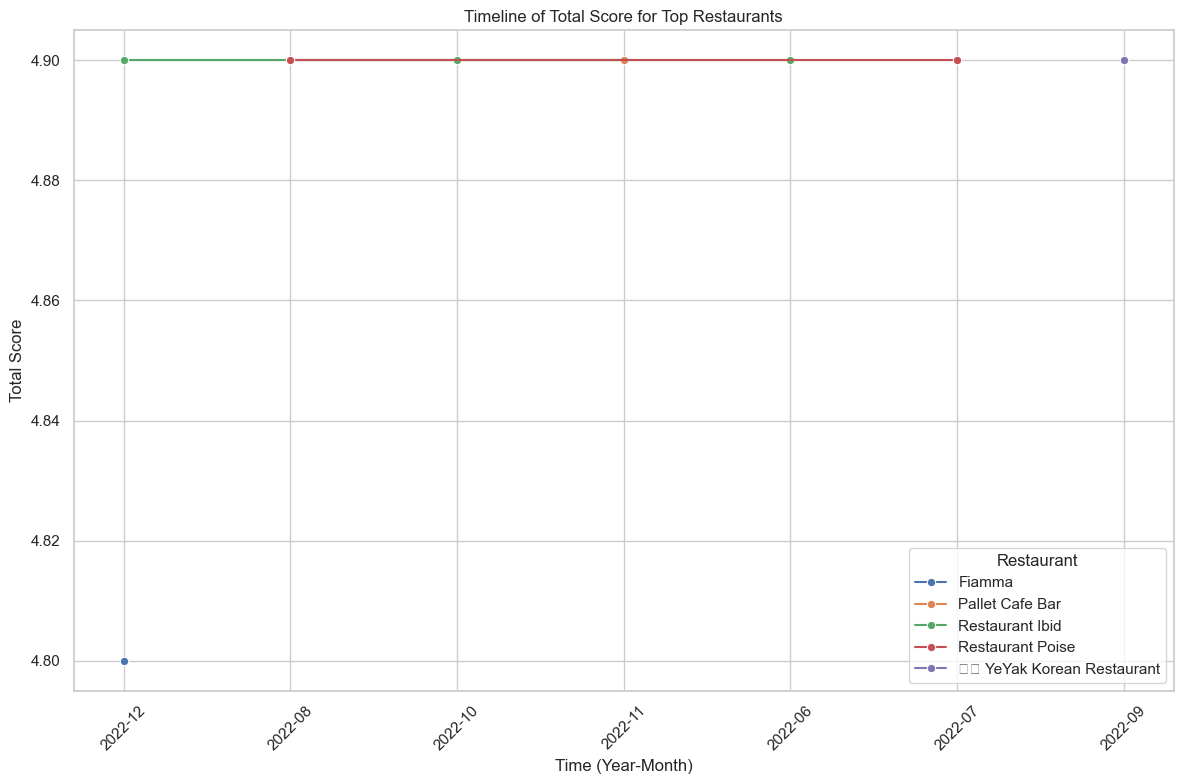

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_restaurant_performance(restaurant_performance):
    # Convert 'year_month' to string for plotting
    restaurant_performance['year_month'] = restaurant_performance['year_month'].astype(str)

    # Set the style of the plot
    sns.set(style="whitegrid")

    # Create a line plot of 'totalScore' over 'year_month' for each 'restaurant'
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=restaurant_performance, x='year_month', y='totalScore', hue='restaurant', marker='o')

    # Set plot labels and title
    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Total Score')
    plt.title('Timeline of Total Score for Top Restaurants')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Show the plot
    plt.legend(title='Restaurant')
    plt.tight_layout()
    plt.show()


# Example usage:
plot_restaurant_performance(restaurant_performance)


Review stars plot

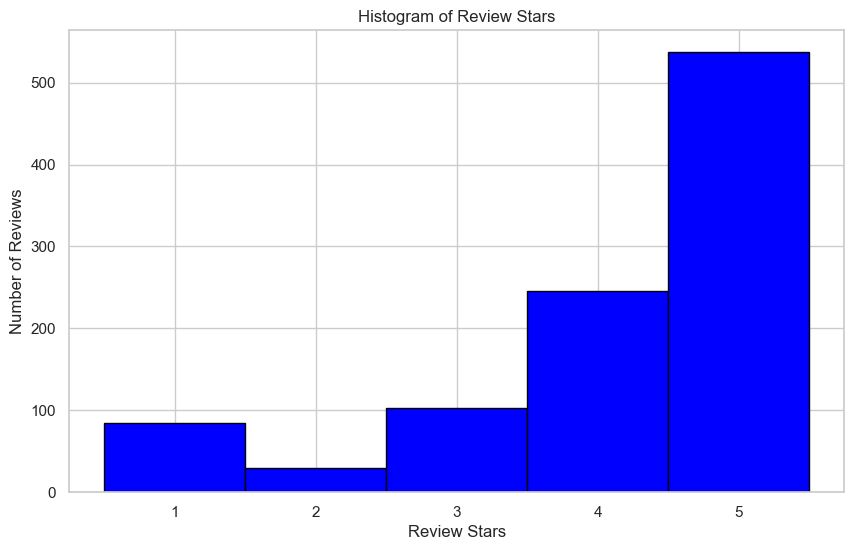

In [52]:
import requests
import matplotlib.pyplot as plt

def query_review_stars(solr_url, collection_name, num_results=1000):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review stars
    params = {
        'q': '*:*',  # Match all documents
        'fl': 'review_stars',  # Fetch the review_stars field
        'rows': num_results,  # Limit number of results to fetch
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        documents = results['response']['docs']
        
        # Extract review stars and convert them to integers
        review_stars = [int(doc['review_stars']) for doc in documents if 'review_stars' in doc]
        return review_stars
    else:
        print('Error:', response.status_code)
        return []

def plot_histogram(review_stars):
    # Plot the histogram of review stars
    plt.figure(figsize=(10, 6))
    plt.hist(review_stars, bins=range(1, 7), align='left', color='blue', edgecolor='black')
    
    # Set the title and labels
    plt.title('Histogram of Review Stars')
    plt.xlabel('Review Stars')
    plt.ylabel('Number of Reviews')

    # Set x-ticks to be the center of each bin
    plt.xticks(range(1, 6))

    # Show the plot
    plt.show()

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
review_stars = query_review_stars(solr_url, collection_name)
plot_histogram(review_stars)


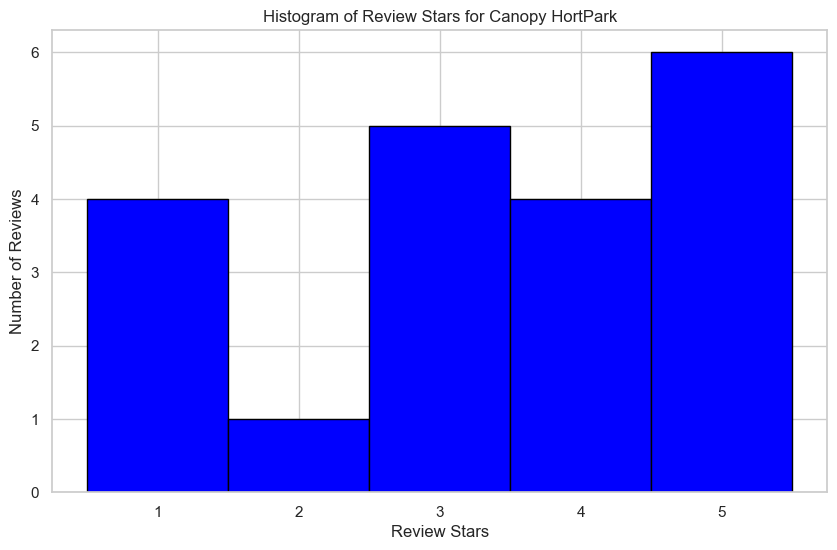

In [78]:
import requests
import matplotlib.pyplot as plt

def query_review_stars_for_restaurant(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review stars for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'review_stars',  # Fetch the review_stars field
        'rows': 1000,  # You might not need all results, adjust as necessary
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        documents = results['response']['docs']
        
        # Extract review stars and convert them to integers
        review_stars = [int(doc['review_stars']) for doc in documents if 'review_stars' in doc]
        return review_stars
    else:
        print('Error:', response.status_code)
        return []

def plot_histogram_for_restaurant(review_stars, restaurant_name):
    # Plot the histogram of review stars for the specific restaurant
    plt.figure(figsize=(10, 6))
    plt.hist(review_stars, bins=range(1, 7), align='left', color='blue', edgecolor='black')
    
    # Set the title and labels
    plt.title(f'Histogram of Review Stars for {restaurant_name}')
    plt.xlabel('Review Stars')
    plt.ylabel('Number of Reviews')

    # Set x-ticks to be the center of each bin
    plt.xticks(range(1, 6))

    # Show the plot
    plt.show()

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
restaurant_name = 'Canopy HortPark'  # Specify the restaurant name
review_stars = query_review_stars_for_restaurant(solr_url, collection_name, restaurant_name)
plot_histogram_for_restaurant(review_stars, restaurant_name)


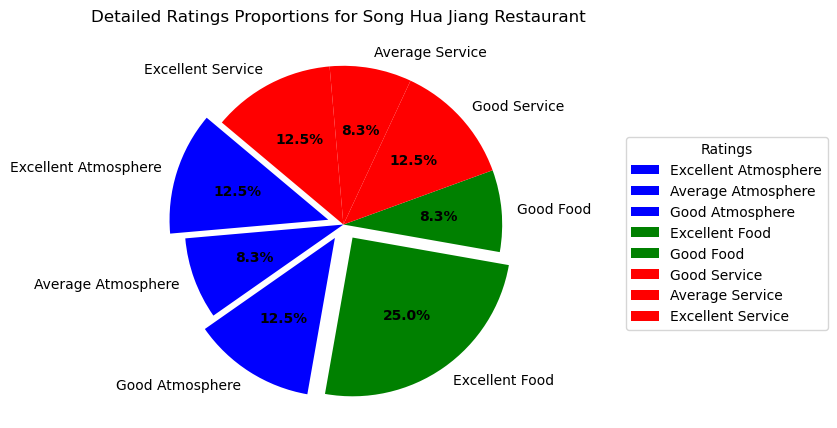

In [2]:
import requests
import matplotlib.pyplot as plt

def query_detailed_ratings(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch detailed ratings for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'reviewDetailedRatingAtmosphere,reviewDetailedRatingFood,reviewDetailedRatingService',  # Fetch the detailed ratings fields
        'rows': 1000,  # Adjust based on expected number of reviews
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        documents = results['response']['docs']
        
        # Extract detailed ratings
        detailed_ratings = {
            'Atmosphere': [],
            'Food': [],
            'Service': []
        }
        for doc in documents:
            if 'reviewDetailedRatingAtmosphere' in doc:
                detailed_ratings['Atmosphere'].append(doc['reviewDetailedRatingAtmosphere'])
            if 'reviewDetailedRatingFood' in doc:
                detailed_ratings['Food'].append(doc['reviewDetailedRatingFood'])
            if 'reviewDetailedRatingService' in doc:
                detailed_ratings['Service'].append(doc['reviewDetailedRatingService'])
                
        return detailed_ratings
    else:
        print('Error:', response.status_code)
        return {}

def plot_pie_chart(detailed_ratings, restaurant_name):
    # Prepare data for pie chart
    labels = []
    sizes = []
    colors = []
    explode = []  # to slightly separate the slices of the pie chart
    for rating_type, ratings in detailed_ratings.items():
        rating_set = set(ratings) - {'NaN'}
        for rating in rating_set:
            labels.append(rating)
            sizes.append(ratings.count(rating))
            explode.append(0.1 if ratings.count(rating) == max(sizes) else 0)  # Highlight the slice with the highest count
            if 'Food' in rating:
                colors.append('green')
            elif 'Atmosphere' in rating:
                colors.append('blue')
            elif 'Service' in rating:
                colors.append('red')
    
    # Plot the pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)

    # Beautify the pie chart
    plt.setp(autotexts, size=10, weight="bold")
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Detailed Ratings Proportions for {restaurant_name}', y=1.05)

    # Create a legend
    ax.legend(wedges, labels,
              title="Ratings",
              loc="center right",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Show the plot
    plt.show()


# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
restaurant_name = 'Song Hua Jiang Restaurant'  # Specify the restaurant name
detailed_ratings = query_detailed_ratings(solr_url, collection_name, restaurant_name)
plot_pie_chart(detailed_ratings, restaurant_name)


Wordcloud

In [64]:
!python -m pip install wordcloud



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Sherwin\AppData\Local\Programs\Python\Python38-32\python.exe -m pip install --upgrade pip


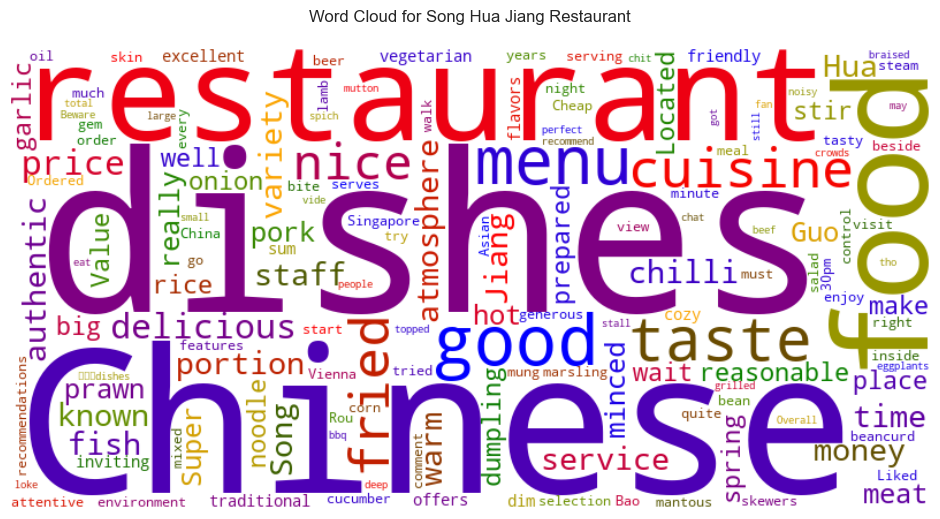

In [84]:
import requests
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def query_reviews(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review text for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'review',  # Fetch the review field
        'rows': 1000,  # Adjust based on expected number of reviews
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        reviews = [doc['review'] for doc in results['response']['docs'] if 'review' in doc]
        return " ".join(reviews)  # Combine all reviews into one text string
    else:
        print('Error:', response.status_code)
        return ""

def generate_word_cloud(text, restaurant_name):
    # Define the color map to use for the word cloud
    colormap = LinearSegmentedColormap.from_list('custom', ['orange', 'green', 'red', 'blue', 'purple'], N=256)
    
    stopwords = set(STOPWORDS)

    # Generate the word cloud image with dynamic colors
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=150, 
        stopwords=stopwords, 
        collocations=False, 
        colormap=colormap,  # Using the colormap defined above
        normalize_plurals=True).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {restaurant_name}', pad=20)
    plt.tight_layout(pad=0)
    plt.show()


# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
restaurant_name = 'Song Hua Jiang Restaurant'  # Specify the restaurant name
reviews_text = query_reviews(solr_url, collection_name, restaurant_name)
generate_word_cloud(reviews_text, restaurant_name)

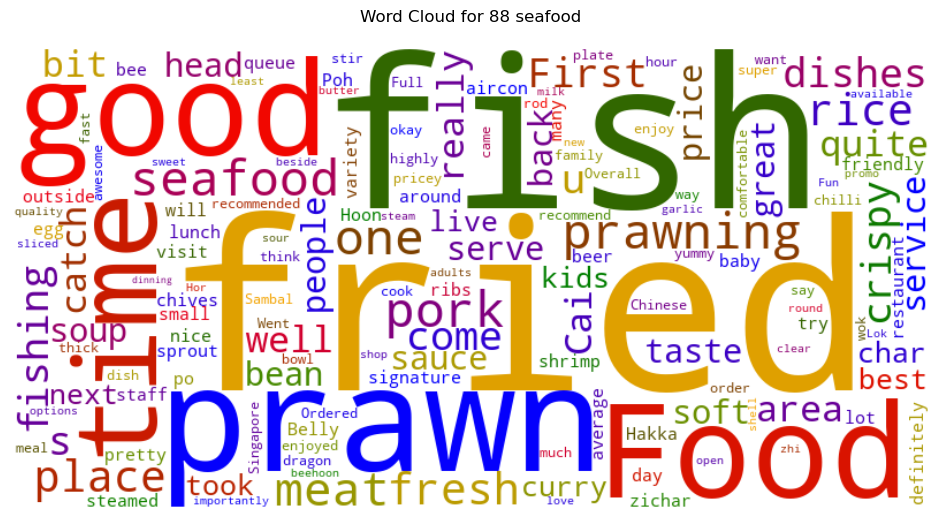

In [3]:
import requests
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def query_reviews(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review text for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'review',  # Fetch the review field
        'rows': 1000,  # Adjust based on expected number of reviews
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        reviews = [doc['review'] for doc in results['response']['docs'] if 'review' in doc]
        return " ".join(reviews)  # Combine all reviews into one text string
    else:
        print('Error:', response.status_code)
        return ""

def generate_word_cloud(text, restaurant_name):
    # Define the color map to use for the word cloud
    colormap = LinearSegmentedColormap.from_list('custom', ['orange', 'green', 'red', 'blue', 'purple'], N=256)
    
    stopwords = set(STOPWORDS)

    # Generate the word cloud image with dynamic colors
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=150, 
        stopwords=stopwords, 
        collocations=False, 
        colormap=colormap,  # Using the colormap defined above
        normalize_plurals=True).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {restaurant_name}', pad=20)
    plt.tight_layout(pad=0)
    plt.show()


# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
restaurant_name = '88 seafood'  # Specify the restaurant name
reviews_text = query_reviews(solr_url, collection_name, restaurant_name)
generate_word_cloud(reviews_text, restaurant_name)

map


In [91]:
!pip install folium


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Sherwin\AppData\Local\Programs\Python\Python38-32\python.exe -m pip install --upgrade pip


radius based search on map, assuming user's location is at ntu

In [95]:
import folium
import requests

def query_restaurant_locations(solr_url, collection_name, center_lat, center_lon, radius_km=5):
    # Calculate bounding box coordinates for the given radius
    lat_delta = radius_km / 110.574  # 1 degree of latitude is approximately 110.574 km
    lon_delta = radius_km / (111.32 * abs(center_lat))  # 1 degree of longitude varies depending on latitude

    lat_min = center_lat - lat_delta
    lat_max = center_lat + lat_delta
    lon_min = center_lon - lon_delta
    lon_max = center_lon + lon_delta

    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch restaurant names and locations within the bounding box
    params = {
        'q': f'LatLong:[{lat_min},{lon_min} TO {lat_max},{lon_max}]',  # Match documents within the bounding box
        'fl': 'restaurant,LatLong',  # Fetch the restaurant and LatLong fields
        'rows': 1000,  # Adjust based on expected number of restaurants
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        locations = [(doc['restaurant'], tuple(map(float, doc['LatLong'].split(','))))
                     for doc in results['response']['docs'] if 'LatLong' in doc]
        return locations
    else:
        print('Error:', response.status_code)
        return []

def create_map(restaurants_locations, center_lat, center_lon):  
    # Create a map instance centered around the specified latitude and longitude
    map_ = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # Add points to the map
    for name, (lat, lon) in restaurants_locations:
        folium.Marker([lat, lon], popup=name).add_to(map_)

    return map_

# Example usage:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  # Replace with your actual collection name
center_lat = 1.3402
center_lon = 103.6755
restaurants_locations = query_restaurant_locations(solr_url, collection_name, center_lat, center_lon)
restaurant_map = create_map(restaurants_locations, center_lat, center_lon)

# Display the map
restaurant_map
